In [96]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler


from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf


import massPy as mp
from utils import get_defect_density, calc_density_fluctuations, get_defect_list

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [ ]:
## TODO:
# - make corr func mem efficient
# ++++ er beregningen langsom eller er det at åbne filerne der er langsomt?

# - TEST sfac, corr on cluster
# - find k scaling for sfactor (hvor skal vi starte den? det virker ikke super vigtigt ift scaling.)
# +++ understand params, dvs directed, unbiased


# - lav plottefunktion dynamisk


In [105]:
def get_pair_corr_function(ar, ball_window, frame_interval = None, rmax = 10, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax), fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax), fv=method_kwargs)
    
    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None):
    """
    Plot pair correlation function
    """
    if pcf_estimated:
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, marker = '.')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def get_structure_factor(ar, box_window, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        sf = StructureFactor(point_pattern)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if i == 0:
            kbins_arr = kbins.astype('float')
            sf_arr = np.empty([Nframes, len(kbins_arr), 2])
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),2))   
    
    ax.set_ylim([sf_min/2, sf_max + 3])
    ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'$|k|$')
    ax.set_ylabel(r'$S(k)$')
    ax.set_title(r'Scaling of structure factor with $k$')
    fig.tight_layout()
    return fig, ax


In [107]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

data_dirs = os.listdir(path)
data_dirs = [os.path.join(path, d) for d in data_dirs]
ar = mp.archive.loadarchive(data_dirs[1])

In [106]:
data_dirs[1]

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\data512'

In [108]:
frame_interval = [0,1]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
window = BoxWindow(bounds=[[0, LX], [0, LY]])   

kbins, sf_arr = get_structure_factor(ar, window, frame_interval = frame_interval, kmax = .5, debiased = True, direct = True, nbins = 50,)

C:\Users\Simon Andersen\structure-factor\src\structure_factor\tapered_estimators.py:94: UserWarning: The computation on all allowed wavevectors may be time-consuming.
  warnings.warn(


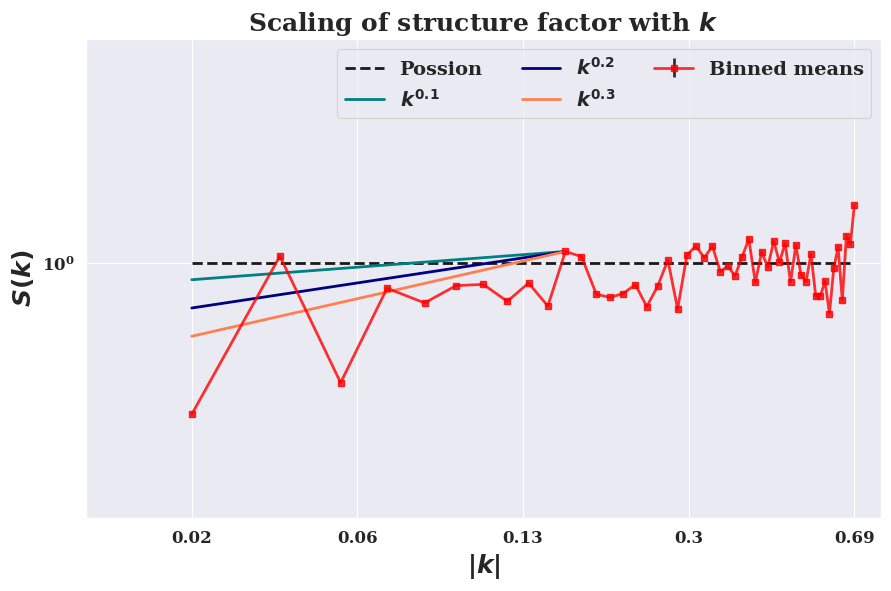

In [109]:
plot_structure_factor(kbins, np.mean(sf_arr[:, :, 0], axis = 0), np.std(sf_arr[:, :, 1], axis = 0));

In [ ]:
frame_interval = [0, 3]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
window = BallWindow(center=[LX/2, LX/2], radius=LX/3) 

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 40))

In [117]:
print("SIZE OF R (MB): ", 1500 * rad_arr.values.itemsize * rad_arr.size  / 1e6)

SIZE OF R (MB):  1.8479999999999999


In [108]:
r_crit = 1.5
Njump_small = 10
Njump_large = 3
idx_crit = np.argmin(np.abs(rad_arr.values - r_crit))

mask = (rad_arr.values < 0)

mask[np.arange(0, idx_crit, Njump_small)] = True
mask[np.arange(idx_crit, len(mask), Njump_large)] = True


print(mask.sum())

154


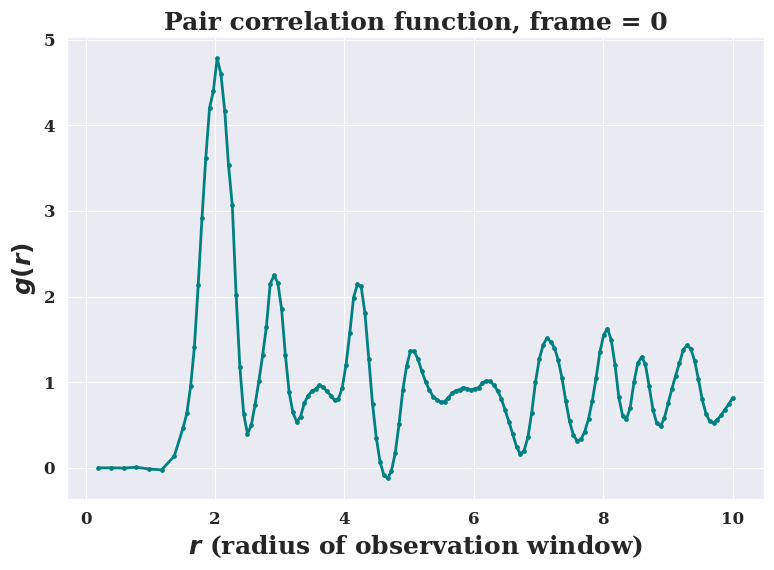

In [109]:
fig, ax = plot_pair_corr_function(rad_arr = rad_arr[mask], pcf_arr = pcf_arr[0][mask], frame = frame_interval[0])